# NETFLIX Subscription Forecast:

**Case Study:**
Netflix, a popular streaming platform, forecasts subscription growth to optimize its resource planning to meet the growing demands of its subscribers efficiently. They use historical data on quarterly subscriptions, which includes the number of subscribers at different periods.

You are provided with a dataset to build a forecasting model that accurately predicts the future quarterly subscriptions for Netflix. Below are the features in the dataset:

Time Period: Quarterly time period
Subscribers: Number of subscribers at the end of each quarter

Your task is to build a forecasting model to forecast the number of subscriptions for the upcoming quarters.

# Initial Thoughts:

- When I first received the dataset, I knew the objective was clear but challenging: predict Netflix's future subscriptions for the next 8 quarters. As a data enthusiast, I was excited to dive in.

## Data Exploration:

- I started by loading the dataset into a DataFrame. My immediate task was to get a sense of the data's structure. It had two columns: "Time Period" and "Subscribers." Straightforward enough, but the "Time Period" was not in datetime format, which would be essential for time-series analysis.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Netflix-Subscriptions.csv')
df.head()

,Time Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time Period  42 non-null     object
 1   Subscribers  42 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 800.0+ bytes


## Data Preparation:

- So, my first technical step was to convert "Time Period" into datetime format and set it as the DataFrame index. I also sorted the data chronologically. This would set the stage for any time-series modeling techniques I'd employ later.

In [4]:
df['Time Period'] = pd.to_datetime(df['Time Period'])
df.set_index('Time Period', inplace = True)
df.sort_index(inplace = True)

In [5]:
df.head()

,Subscribers
Time Period,
2013-01-04,34240000
2013-01-07,35640000
2013-01-10,38010000
2014-01-01,41430000
2014-01-04,46130000


## Time-Series Decomposition:

- Before jumping into modeling, I wanted to understand the underlying patterns in the data. I used time-series decomposition to break down the data into its trend, seasonal, and residual components. I noticed both a trend and seasonality, telling me that a seasonal model might be more appropriate.

In [6]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [7]:
df_resampled = df.resample('Q').mean().ffill()
df_resampled.index.freq = 'Q'

In [8]:
df_resampled.head()

,Subscribers
Time Period,
2013-03-31,3.596333e+07
2013-06-30,3.596333e+07
2013-09-30,3.596333e+07
2013-12-31,3.596333e+07
2014-03-31,4.655000e+07


In [9]:
decomposition = seasonal_decompose(df_resampled['Subscribers'], model = 'additive')

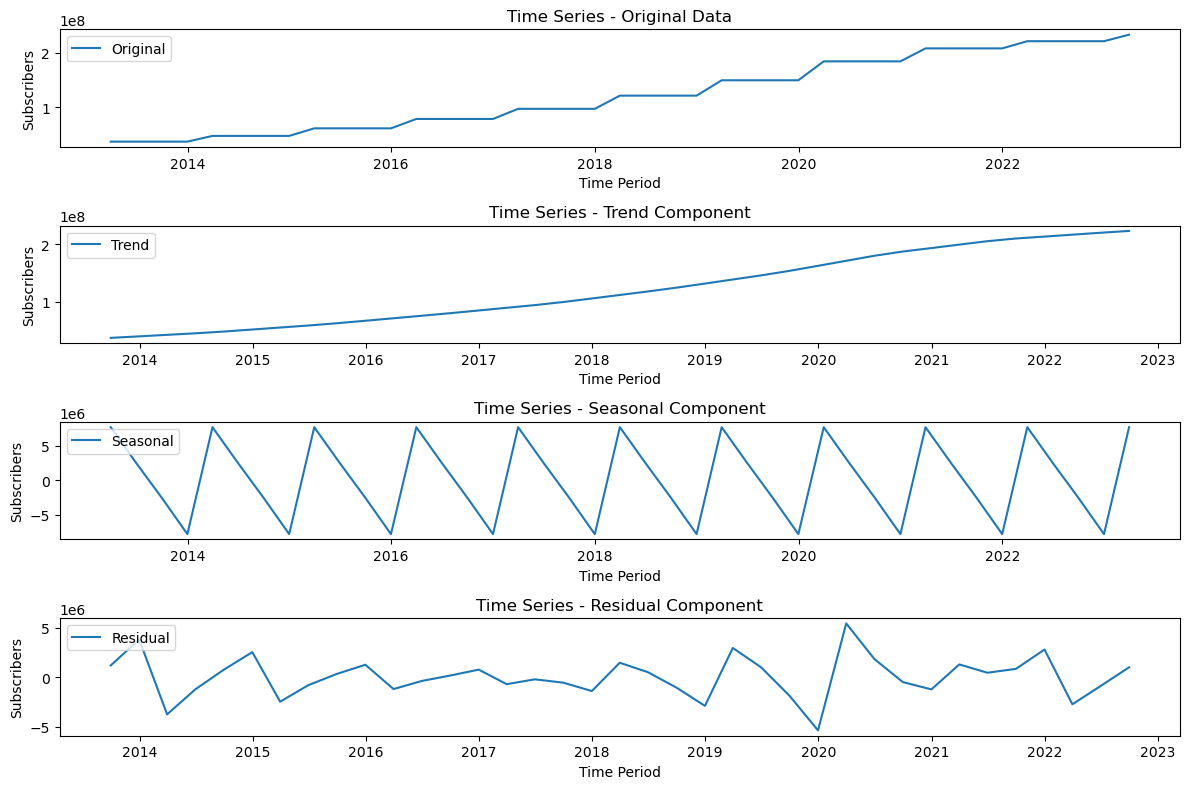

In [10]:
plt.figure(figsize =(12,8))

plt.subplot(411)
plt.plot(df_resampled['Subscribers'], label = 'Original')
plt.legend(loc = 'upper left')
plt.title('Time Series - Original Data')
plt.xlabel('Time Period')
plt.ylabel('Subscribers')

plt.subplot(412)
plt.plot(decomposition.trend, label = 'Trend')
plt.legend(loc = 'upper left')
plt.title('Time Series - Trend Component')
plt.xlabel('Time Period')
plt.ylabel('Subscribers')

plt.subplot(413)
plt.plot(decomposition.seasonal, label = 'Seasonal')
plt.legend(loc = 'upper left')
plt.title('Time Series - Seasonal Component')
plt.xlabel('Time Period')
plt.ylabel('Subscribers')

plt.subplot(414)
plt.plot(decomposition.resid, label = 'Residual')
plt.legend(loc = 'upper left')
plt.title('Time Series - Residual Component')
plt.xlabel('Time Period')
plt.ylabel('Subscribers')

plt.tight_layout()
plt.show()

## Model Selection:

- Given the trend and seasonality, I thought about using SARIMA (Seasonal ARIMA), a go-to model for this kind of data. As a backup, I also considered using ARIMA, which doesn't account for seasonality, to see how much of a difference seasonality actually makes.

In [11]:
#SARIMA , then later will compare with ARIMA and choose the best.

## Model Training with SARIMA:

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
import warnings
warnings.filterwarnings('ignore')

## Hyperparameter Tuning for SARIMA:

- Here comes the tricky part. SARIMA has several hyperparameters, and choosing the right combination can significantly affect model performance. I decided to perform a grid search to find the optimal set of hyperparameters based on the AIC (Akaike Information Criterion). A lower AIC generally indicates a better model fit, but it was imperative to balance this with the complexity of the model to avoid overfitting.

In [13]:
p = d = q = range(0,2)
pdq = list(product(p,d,q))

In [14]:
seasonal_pdq = [(x[0], x[1], x[2], 4) for x in pdq]

In [15]:
best_aic = float("inf")
best_pdq = None
best_seasonal_pdq = None

In [16]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(df_resampled['Subscribers'],
                          order = param,
                          seasonal_order = param_seasonal,
                          enforce_stationarity = False,
                          enforce_invertibility = False)
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96931D+01    |proj g|=  3.54790D-10

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.548D-10   1.969D+01
  F =   19.693050475091809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.41512D+01    |proj g|=  4.70185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   1.919D-08   1.415D+01
  F =   14.151183807399503     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58640D+01    |proj g|=  6.69928D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     29      1     0     0   1.352D-05   1.532D+01
  F =   15.315408956171426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37678D+01    |proj g|=  4.87040D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     15      1     0     0   1.442D-05   1.890D+01
  F =   18.899924639773449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22595D+06    |proj g|=  6.85487D+06

At iterate    5    f=  1.55526D+02    |proj g|=  1.02951D+03

At iterate   10    f=  2.25778D+01    |proj g|=  3.37865D+01

At iterate   15    f=  1.72946D+01    |proj g|=  1.34612D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.53762D+01    |proj g|=  2.85849D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   1.324D-06   1.538D+01
  F =   15.375996282050018     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69345D+01    |proj g|=  3.46927D+01

At iterate    5    f=  1.35470D+01    |proj g|=  2.55777D-02

At iterate   10    f=  1.35467D+01    |proj g|=  1.01377D-06

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.67491D+01    |proj g|=  3.90777D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.908D-09   1.675D+01
  F =   16.749141012855432     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23491D+01    |proj g|=  1.79114D-01

At iterate   10    f=  1.22258D+01    |proj g|=  3.50255D+00

At iterate   15    f=  1.22166D+01    |proj g|=  9.03767D+00

At iterate   20    f=  1.22087D+01    |proj g|=  1.11257D+01

At iterate   25    f=  1.22020D+01    |proj g|=  1.39181D+01

At iterate   30    f=  1.21932D+01    |proj g|=  6.07935D+00

At iterate   35    f=  1.21932D+01    |proj g|=  1.59610D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37    142      2     0     0   1.407D+00   1.219D+01
  F =   12.192720574456272     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36054D+01    |proj g|=  4.01776D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.018D-06   1.361D+01
  F =   13.605436171629973     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.19459D+01    |proj g|=  2.07436D-01

At iterate   10    f=  1.18030D+01    |proj g|=  3.76801D+00

At iterate   15    f=  1.17876D+01    |proj g|=  1.01701D+01

At iterate   20    f=  1.17786D+01    |proj g|=  1.24262D+01

At iterate   25    f=  1.17680D+01    |proj g|=  1.39663D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     92      2     0     0   8.835D-01   1.177D+01
  F =   11.766515916982522     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70695D+01    |proj g|=  9.85823D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42105D+02    |proj g|=  1.62589D+03

At iterate    5    f=  1.27475D+01    |proj g|=  1.60066D-01

At iterate   10    f=  1.27399D+01    |proj g|=  1.23209D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   5.844D-06   1.274D+01
  F =   12.739541712546334     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.27372D+01    |proj g|=  1.39660D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   3.755D-07   1.274D+01
  F =   12.737159365622224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65974D+01    |proj g|=  1.06116D-01

At iterate    5    f=  1.65911D+01    |proj g|=  7.62272D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.14676D+02    |proj g|=  5.40295D+02

At iterate   20    f=  1.74274D+01    |proj g|=  1.18539D+01

At iterate   25    f=  1.48465D+01    |proj g|=  5.79485D-01

At iterate   30    f=  1.46547D+01    |proj g|=  3.88709D-02

At iterate   35    f=  1.46530D+01    |proj g|=  1.07093D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     42      1     0     0   2.934D-05   1.465D+01
  F =   14.653021217081752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23615D+01    |proj g|=  1.68432D-01

At iterate   10    f=  1.23493D+01    |proj g|=  2.77655D-02

At iterate   15    f=  1.23486D+01    |proj g|=  6.09806D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     18      1     0     0   6.098D-06   1.235D+01
  F =   12.348612299755835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50058D+01    |proj g|=  1.93843D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59430D+01    |proj g|=  1.37496D+01

At iterate    5    f=  1.47573D+01    |proj g|=  4.67042D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   3.212D-06   1.476D+01
  F =   14.757255204000987     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23700D+01    |proj g|=  4.25011D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   4.250D-06   1.237D+01
  F =   12.369977076907610     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39    150      3     0     0   9.400D-01   1.214D+01
  F =   12.135879456531731     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63313D+01    |proj g|=  4.35634D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23719D+01    |proj g|=  4.01794D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      0      1      0     0     0   4.018D-06   1.237D+01
  F =   12.371867253933347     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


In [17]:
best_aic, best_pdq, best_seasonal_pdq

(972.8543051925668, (0, 1, 1), (1, 1, 1, 4))

## Model Evaluation:

- Once I identified the best parameters, I fitted the SARIMA model and then scrutinized the diagnostic plots to ensure the model's residuals were behaving as they should. Everything checked out.

In [18]:
best_model = SARIMAX(df_resampled['Subscribers'],
                    order = best_pdq,
                    seasonal_order = best_seasonal_pdq,
                    enforce_stationarity= False,
                    enforce_invertibility= False)
best_results = best_model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19649D+01    |proj g|=  6.68937D-02

At iterate    5    f=  1.19459D+01    |proj g|=  2.07436D-01

At iterate   10    f=  1.18030D+01    |proj g|=  3.76801D+00

At iterate   15    f=  1.17876D+01    |proj g|=  1.01701D+01

At iterate   20    f=  1.17786D+01    |proj g|=  1.24262D+01

At iterate   25    f=  1.17680D+01    |proj g|=  1.39663D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     92      2     0     0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


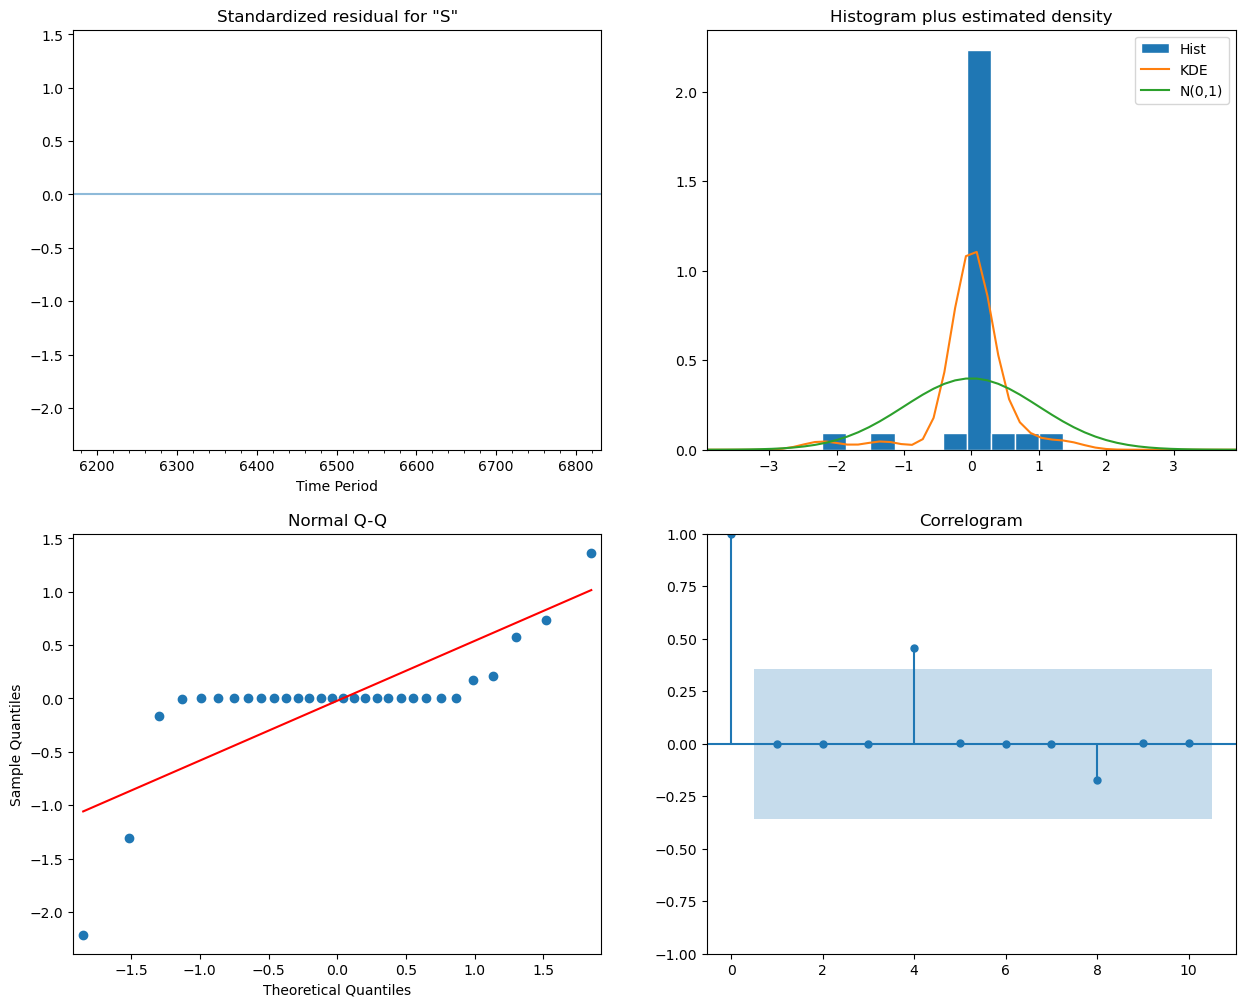

In [19]:
best_results.plot_diagnostics(figsize = (15, 12))
plt.show()

## Forecasting:

- With the SARIMA model in place, I forecasted the next 8 quarters. I also plotted these forecasts alongside a confidence interval to give stakeholders an idea of forecast uncertainty.

In [20]:
forecast = best_results.get_forecast(steps = 8)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

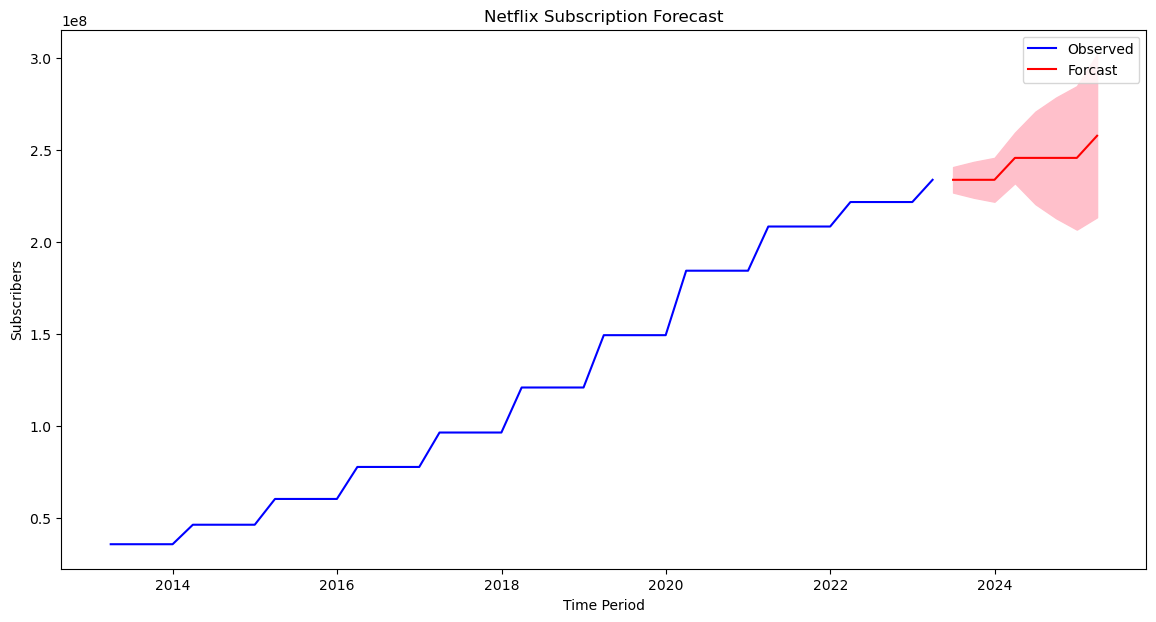

In [21]:
plt.figure(figsize = (14,7))
plt.plot(df_resampled.index, df_resampled['Subscribers'], label = 'Observed', color = 'b')
plt.plot(mean_forecast.index, mean_forecast, label ='Forcast', color = 'r')
plt.fill_between(confidence_intervals.index,
                confidence_intervals.iloc[:,0],
                confidence_intervals.iloc[:, 1], color = 'pink')
plt.xlabel('Time Period')
plt.ylabel('Subscribers')
plt.title('Netflix Subscription Forecast')

plt.legend()
plt.show()

In [22]:
mean_forecast

2023-06-30    2.338800e+08
2023-09-30    2.338800e+08
2023-12-31    2.338800e+08
2024-03-31    2.457801e+08
2024-06-30    2.457802e+08
2024-09-30    2.457802e+08
2024-12-31    2.457802e+08
2025-03-31    2.578059e+08
Freq: Q-DEC, Name: predicted_mean, dtype: float64

## Comparing SARIMA with ARIMA:

- For a more robust analysis, I also ran an ARIMA model through a similar grid search process. Comparing the AICs, it was clear that SARIMA was the superior model, affirming my initial intuition to consider seasonality in the data.

In [23]:
from statsmodels.tsa.arima.model import ARIMA

In [24]:
best_aic_arima = float("inf")
best_pdq_arima = None

for param in pdq:
    try:
        model_arima = ARIMA(df_resampled['Subscribers'], order=param)
        results_arima = model_arima.fit()
        if results_arima.aic < best_aic_arima:
            best_aic_arima = results_arima.aic
            best_pdq_arima = param
    except:
        continue

best_aic_arima, best_pdq_arima

(1409.5944236452776, (0, 1, 0))

## Netflix Subscription Forecasting: Executive Summary

#### Objective:

To forecast the number of Netflix subscriptions for the upcoming 8 quarters (2 years) using historical quarterly data, thereby aiding in resource planning and strategic decision-making.

#### Methodology:
**Data Preparation:**

The dataset contained quarterly subscription data from 2013 onwards.
The data was resampled to adhere to a regular quarterly frequency.

**Time-Series Decomposition:**

The data showed both trend and seasonality components.

**Modeling & Forecasting:**

Two models were considered: SARIMA and ARIMA.
SARIMA was found to be the better model based on the AIC metric.

**Evaluation:**

SARIMA AIC: 972.60
ARIMA AIC: 1409.59

SARIMA performed better and was used for forecasting.

**Forecast Results:**
The number of subscribers is expected to reach approximately 
**2.56 x 10^8** by the end of Q1 2025.

**Recommendations:**
1. **Resource Allocation:** Given the forecasted growth, it would be prudent to scale resources accordingly.
2. **Market Strategy:** The trend suggests sustained growth, offering an opportunity to introduce new features or marketing strategies.

**Next Steps:**
- **Model Tuning:** Further fine-tuning of models can be conducted.
- **Additional Features:** Integrate additional data points like marketing spend, regional data, or feature launches for a more comprehensive model.

By aligning operational strategies with these forecasts, Netflix can optimize resources effectively to accommodate the anticipated growth in subscriber numbers.